In [195]:
import pandas as pd
import os.path as op
import nibabel as nb
import numpy as np
import json
import trimesh
import open3d as o3d
from tools import smooth_csd
import matplotlib.pylab as plt
from matplotlib import cm, colors
from utilities import files
import tqdm.auto as tqdm
from copy import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, minmax_scale
from sklearn.manifold import MDS
from scipy.spatial.distance import euclidean

In [78]:
def data_to_rgb(data, n_bins, cmap, vmin, vmax, vcenter=0, ret_map=False, norm="TS"):
    if norm == "TS":
        divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    elif norm == "N":
        divnorm = colors.Normalize(vmin=vmin, vmax=vmax)
    c = cm.ScalarMappable(divnorm, cmap=cmap)
    bins = np.histogram_bin_edges(data, bins=n_bins)
    bin_ranges = list(zip(bins[:-1], bins[1:]))
    colour_mapped = np.zeros((data.shape[0], 4))
    for br_ix, br in enumerate(bin_ranges):
        map_c = (data >= br[0]) & (data < br[1])
        colour_mapped[map_c,:] = c.to_rgba(bins[1:][br_ix])
    if not ret_map:
        return colour_mapped
    elif ret_map:
        return colour_mapped, c


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap="RdBu_r"
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()


In [3]:
info_path = "/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/info.json"
with open(info_path, "r") as fp:
    info = json.load(fp)

In [4]:
atlas = pd.read_csv(info["atlas"])
atlas_labels = np.load(info["atlas_colors_path"])

csd_files = files.get_files(
    op.join(info["subject_path"], "inverted"),
    "time_CSD", "npy"
)[2]

In [5]:
times = {
    "visual": np.linspace(-0.2, 0.8, num=601),
    "motor": np.linspace(-0.5, 0.5, num=601)
}

In [6]:
ROI_labels = ["L_V1_ROI", "R_V1_ROI"]
total_ix = np.arange(atlas_labels.shape[0])
ROI_vertices = {i: total_ix[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
cds = np.load(csd_files[1])

In [7]:
true_CSD = {}
for l in ROI_labels:
    true_CSD[l] = []
    for rv in ROI_vertices[l]:
        true_CSD[l].append(cds[rv, :, :])

In [173]:
erp_ixs = np.where((times["visual"] >= 0) & (times["visual"] <= 0.2))[0]

In [179]:
csds = np.array([i[:,erp_ixs].flatten() for i in true_CSD["L_V1_ROI"]])
csds.shape

(725, 1331)

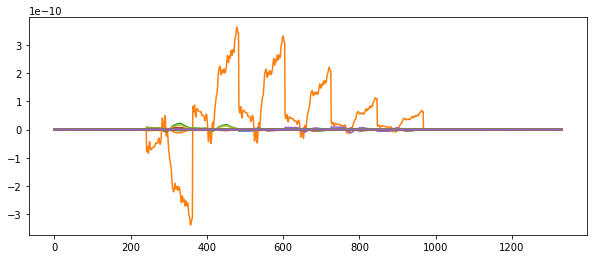

In [180]:
f, ax = plt.subplots(1, figsize=(10, 4))
ax.plot(csds.T);

In [181]:
mean_cds = csds.std(axis=1)
nan_map = np.isnan(mean_cds)
prc_minmax = np.percentile(mean_cds[~nan_map], 1), np.percentile(mean_cds[~nan_map], 99)
outlier_map = (mean_cds < prc_minmax[0]) | (mean_cds > prc_minmax[1])
unwanted_map = nan_map | outlier_map

In [182]:
csds.shape

(725, 1331)

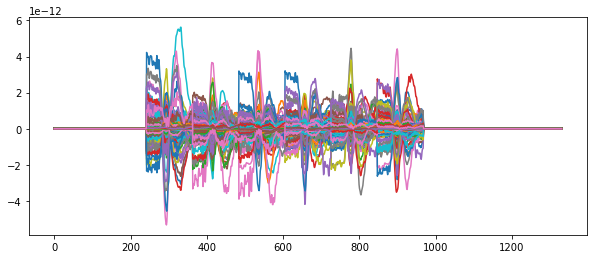

In [183]:
f, ax = plt.subplots(1, figsize=(10, 4))
ax.plot(csds[~unwanted_map].T);

In [187]:
scaler = RobustScaler()
ds = scaler.fit_transform(csds[~unwanted_map])
pca = PCA(n_components=30)
ds_pca = pca.fit_transform(ds)

<BarContainer object of 30 artists>

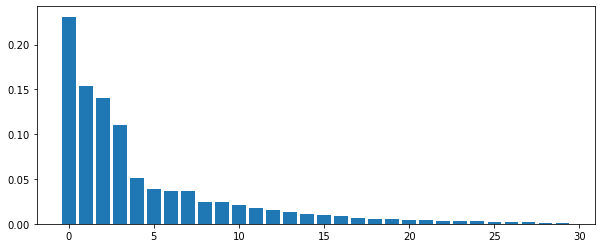

In [188]:
f, ax = plt.subplots(1, figsize=(10, 4))
ax.bar(np.arange(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_)

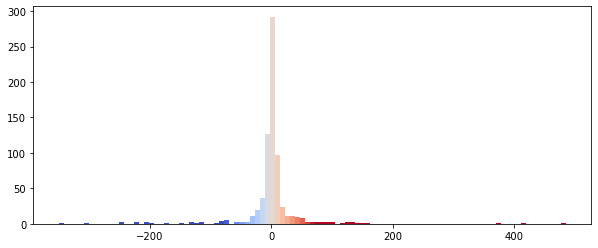

In [208]:
data_pc = ds_pca[:,0]


colormap_dist, mappable = data_to_rgb(np.array(distance), 101, "coolwarm", -75, 75, ret_map=True)

f, ax = plt.subplots(1, figsize=(10, 4))
hist, bins, barlist = ax.hist(data_pc, bins=101);
for ix, xx in enumerate(barlist):
    plt.setp(xx, "facecolor", mappable.to_rgba(bins[ix+1]))

In [63]:
low_dim = MDS(n_components=2)
low_dim_transformed = low_dim.fit_transform(clust_dist)

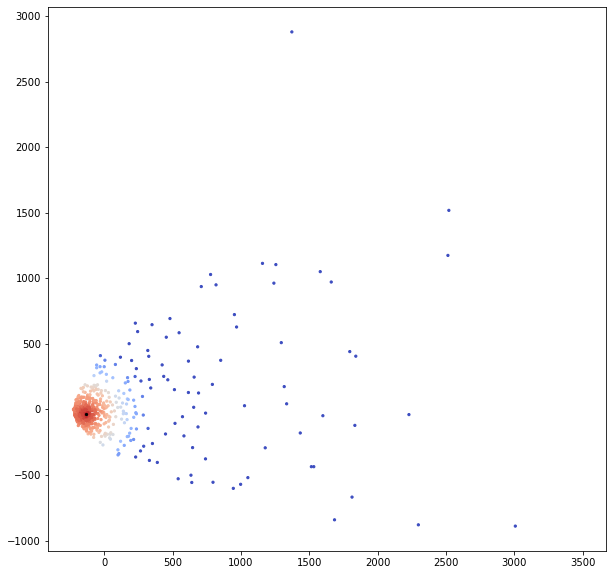

In [156]:
f, ax = plt.subplots(1, figsize=(10,10))
# ax.scatter(low_dim_transformed[:,0], low_dim_transformed[:,1])
# ax.scatter([np.median(low_dim_transformed[:,0])], [np.median(low_dim_transformed[:,1])])

median_point = np.median(low_dim_transformed[:,0]), np.median(low_dim_transformed[:,1])
distance = [euclidean(median_point, p) for ix, p in enumerate(low_dim_transformed)]

colormap_dist, mappable = data_to_rgb(np.array(distance), 200, "coolwarm_r", 0, 500, norm="N", ret_map=True)
ax.scatter((low_dim_transformed[:,0]), low_dim_transformed[:,1], c=colormap_dist, s=5)
ax.scatter([median_point[0]],[median_point[1]], s=5, c="black")
# f, ax = plt.subplots(1, figsize=(10,5))
# ax.hist(distance, bins=20)

In [171]:
data_colour_map = np.repeat(np.array([[0, 1, 0.224]]), ROI_vertices["L_V1_ROI"].shape[0], axis=0)
data_colour_map[~unwanted_map] = colormap_dist[:,:3]
gray = np.array([0.5, 0.5, 0.5])
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices["L_V1_ROI"]):
    colours[v] = data_colour_map[ix][:3]

mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
vxmask = np.array([i.decode("utf=8")[0] == "R" for i in atlas_labels]) | np.array([i.decode("utf=8")[0] == "?" for i in atlas_labels])
mesh.remove_vertices_by_mask(vxmask)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

In [172]:
data_colour_map = np.repeat(np.array([[0, 1, 0.224]]), ROI_vertices["L_V1_ROI"].shape[0], axis=0)
data_colour_map[~unwanted_map] = colormap_dist[:,:3]
gray = np.array([0.5, 0.5, 0.5])
brain = nb.load(info["pial_ds_nodeep"])
vertices, faces, normals = brain.agg_data()
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices["L_V1_ROI"]):
    colours[v] = data_colour_map[ix][:3]

mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
vxmask = np.array([i.decode("utf=8")[0] == "R" for i in atlas_labels]) | np.array([i.decode("utf=8")[0] == "?" for i in atlas_labels])
mesh.remove_vertices_by_mask(vxmask)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

In [167]:
SMOOTH_CSD = {}
for l in ROI_labels:
    SMOOTH_CSD[l] = []
    for rv in ROI_vertices[l]:
        SMOOTH_CSD[l].append(smooth_csd(cds[rv, :, :], info["n_surf"]))

smooth_csds = np.array(SMOOTH_CSD["L_V1_ROI"])
smooth_csds = smooth_csds[~unwanted_map]

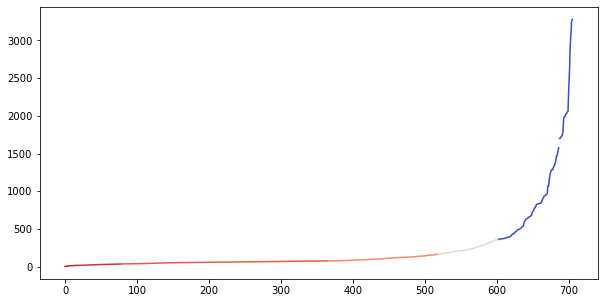

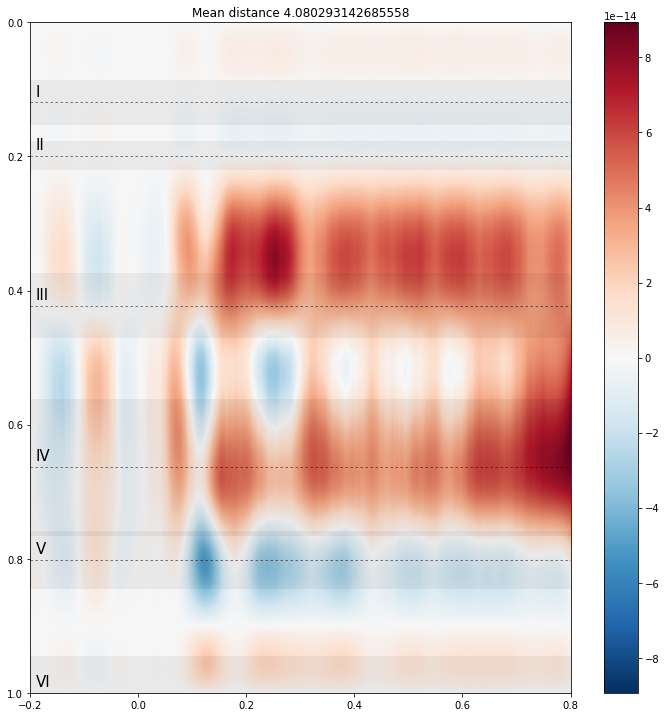

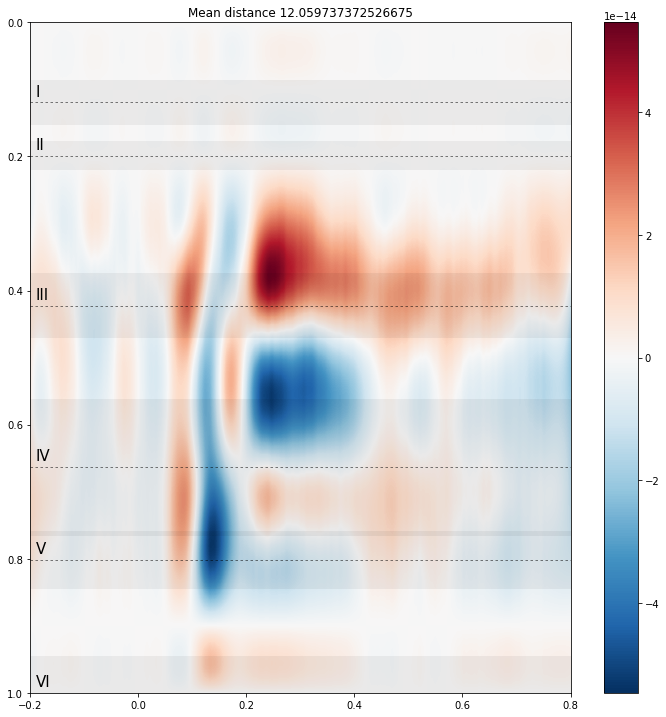

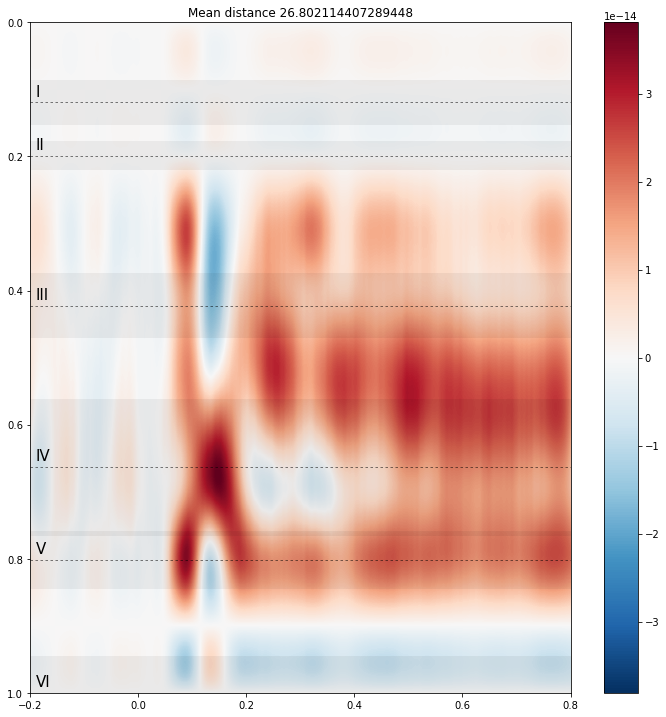

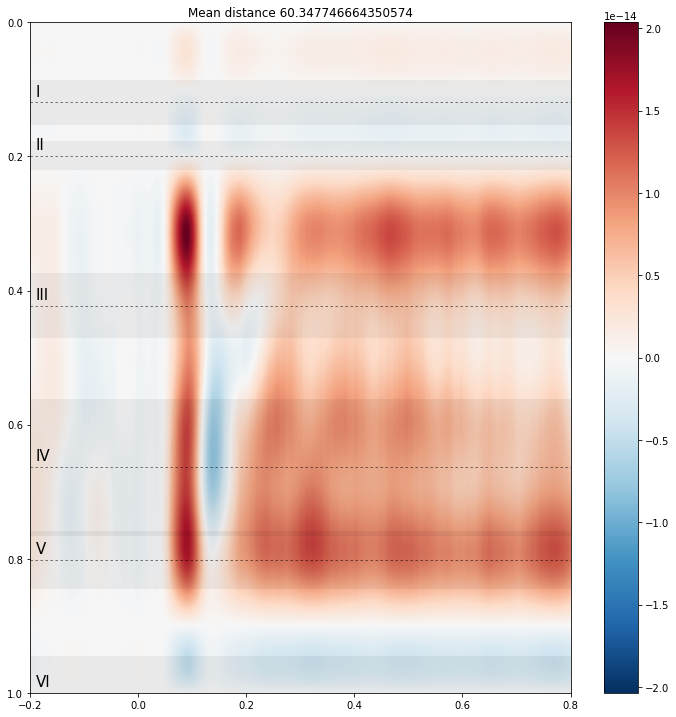

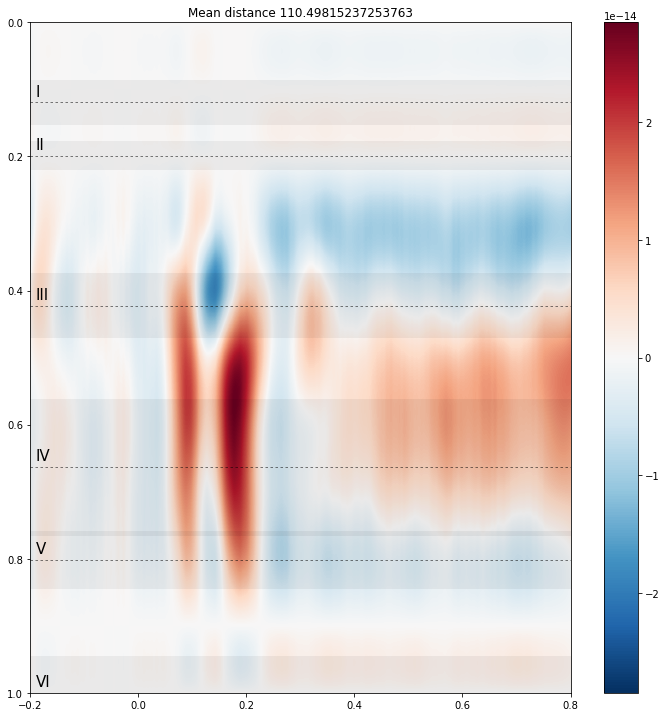

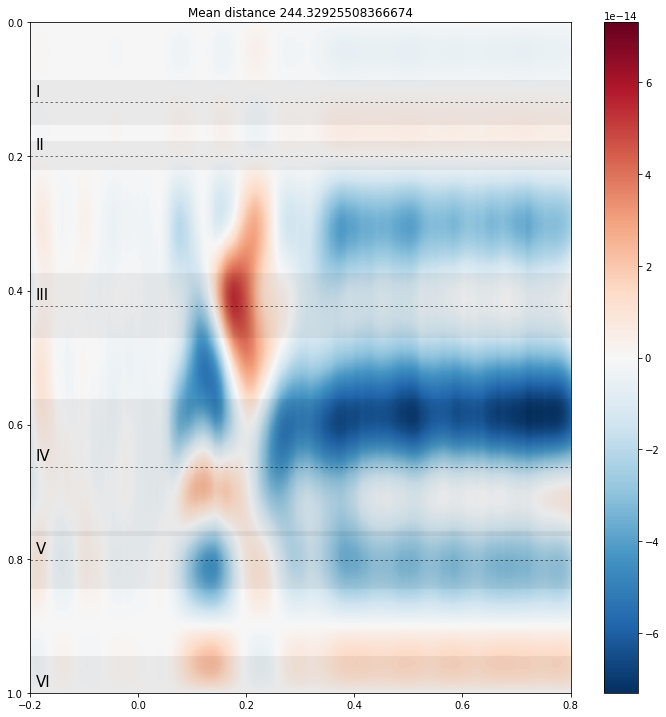

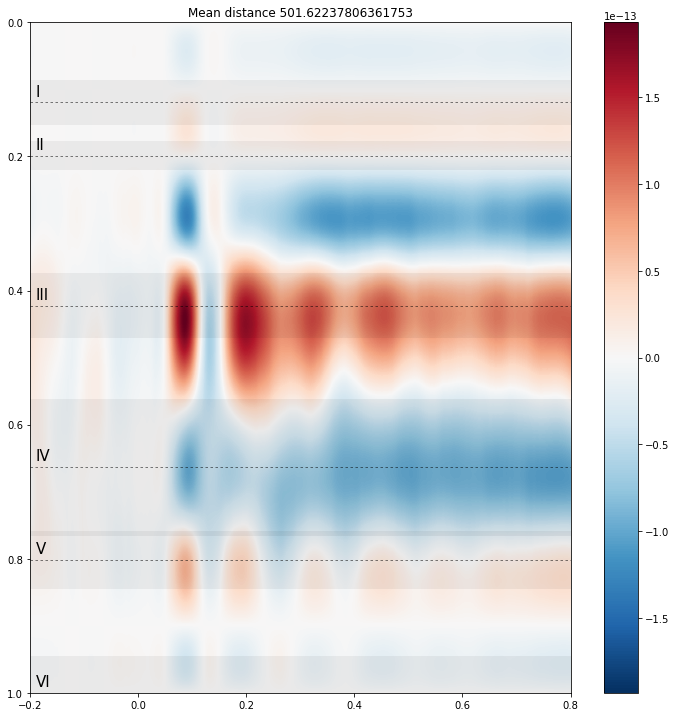

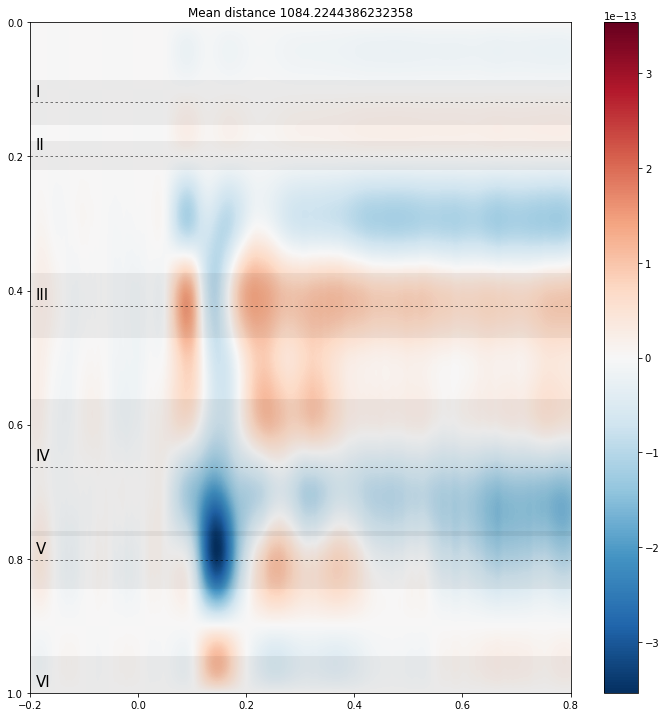

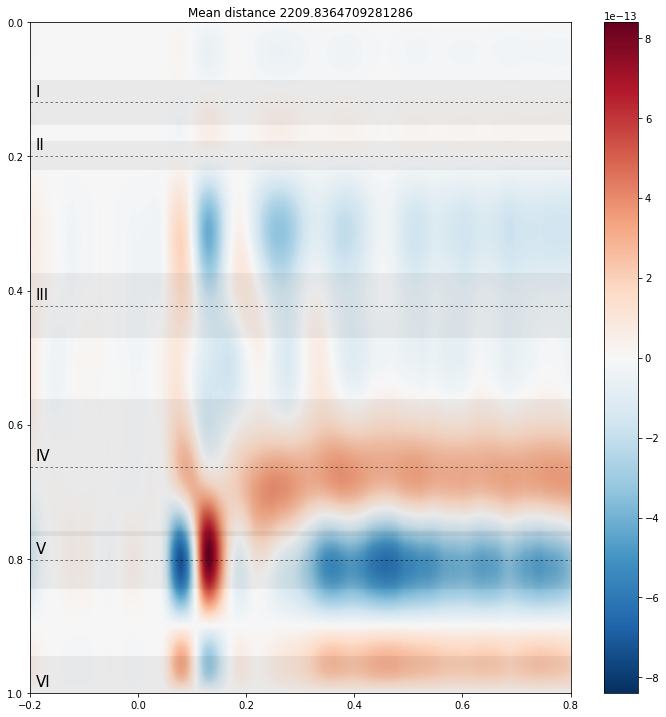

In [170]:
dist_copy = copy(distance)
dist_copy.sort()
dist_copy = np.array(dist_copy)
x = np.arange(dist_copy.shape[0])


minmax_log = np.min(np.log10(dist_copy)), np.max(np.log10(dist_copy))
score_bounds = np.logspace(minmax_log[0], minmax_log[1], num=10, dtype="int", base=10, endpoint=True)
score_ranges = list(zip(score_bounds[:-1], score_bounds[1:]))

f, ax = plt.subplots(1, figsize=(10,5))
for r in score_ranges:
    xxx = np.where((dist_copy >= r[0]) & (dist_copy < r[1]))[0]
    ax.plot(x[xxx], dist_copy[xxx], c=mappable.to_rgba(np.mean(dist_copy[xxx])))
    
for r in score_ranges:
    distance_mask = np.where((distance >= r[0]) & (distance < r[1]))[0]
    mean_smooth_csd = np.mean(smooth_csds[distance_mask], axis=0)
    baseline = np.mean(mean_smooth_csd[:, np.where(times["visual"] < -0.01)], axis=2)
    f, ax = plt.subplots(1, figsize=(10, 10))
    plot_csd(
        mean_smooth_csd - baseline, ROI_vertices["L_V1_ROI"],
        info["big_brain_layers_path"], times["visual"], ax
    )
    ax.set_title("Mean distance {}".format(np.mean(np.array(distance)[distance_mask])))

array([ True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,